# JALA Data Scientist Take Home Test
- **Author:** Muhammad Arfian Praniza
- **Email:** fianpraniza@gmail.com
- **Linkedin:** https://www.linkedin.com/in/fianpraniza/
- **Contact:** +6281259676839

Import Libraries dan Loading Data

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from datetime import datetime
warnings.filterwarnings('ignore')

Persiapan Data untuk Modeling

In [2]:
def load_processed_data():
    try:
        main_df = pd.read_csv('processed_data/main_dataset.csv')
        
        # Konversi kolom tanggal kembali ke datetime dengan penanganan format yang lebih fleksibel
        date_columns = ['started_at', 'finished_at', 'harvested_at']
        for col in date_columns:
            if col in main_df.columns:
                try:
                    # Coba format ISO8601 terlebih dahulu
                    main_df[col] = pd.to_datetime(main_df[col], format='ISO8601')
                except ValueError:
                    try:
                        # Jika gagal, coba format YYYY-MM-DD
                        main_df[col] = pd.to_datetime(main_df[col], format='%Y-%m-%d')
                    except ValueError:
                        # Jika masih gagal, gunakan parser otomatis
                        main_df[col] = pd.to_datetime(main_df[col], format='mixed')
                
                print(f"Kolom {col} berhasil dikonversi ke datetime")
        
        print("Dataset berhasil dimuat dengan dimensi:", main_df.shape)
        return main_df
    except FileNotFoundError:
        print("File processed_data/main_dataset.csv tidak ditemukan!")
        return None
    except Exception as e:
        print(f"Terjadi kesalahan saat memuat data: {str(e)}")
        return None

In [3]:
def prepare_features(df, target_type='sr'):
    """
    Menyiapkan fitur untuk model prediksi SR atau ABW dengan penanganan NaN
    
    Parameters:
    df : DataFrame hasil preprocessing
    target_type : str, 'sr' untuk Survival Rate atau 'abw' untuk Average Body Weight
    """
    print(f"\nMenyiapkan data untuk model {target_type.upper()}")
    
    # Daftar fitur yang akan digunakan
    base_features = [
        'stocking_density', 'pond_volume', 'surface_to_volume_ratio',
        'culture_duration', 'temp_daily_fluctuation'
    ]
    
    water_quality_features = [col for col in df.columns if any(x in col for x in 
        ['temperature', 'do', 'salinity', 'pH', 'ammonia', 'nitrate', 'nitrite'])]
    
    # Fitur musiman
    seasonal_features = ['start_month', 'start_quarter']
    
    # Gabungkan semua fitur
    features = base_features + water_quality_features + seasonal_features
    
    # Pilih fitur yang tersedia di dataset
    available_features = [f for f in features if f in df.columns]
    
    # Siapkan X (fitur)
    X = df[available_features].copy()
    
    # Siapkan y (target)
    if target_type == 'sr':
        y = df['survival_rate'].copy()
    else:  # ABW
        y = df['average_weight'].copy()
    
    # Print informasi tentang missing values sebelum penanganan
    print("\nJumlah missing values sebelum penanganan:")
    print("Features:")
    print(X.isnull().sum().sum(), "total missing values in features")
    print("\nTarget:")
    print(y.isnull().sum(), "missing values in target")
    
    # Hapus baris dengan nilai NaN pada target
    valid_indices = ~y.isnull()
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]
    
    # Handle missing values pada fitur
    X = X.fillna(X.mean())
    
    # One-hot encoding untuk fitur kategorikal
    categorical_features = ['start_month', 'start_quarter']
    for feature in categorical_features:
        if feature in X.columns:
            X = pd.get_dummies(X, columns=[feature], prefix=feature)
    
    print("\nSetelah penanganan missing values:")
    print(f"Jumlah sampel: {len(X)}")
    print(f"Jumlah fitur: {len(X.columns)}")
    print("\nFitur yang digunakan:")
    print(X.columns.tolist())
    
    return X, y

In [4]:
# splitting dataset
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Membagi data menjadi training dan testing set
    """
    print("\nMelakukan split dataset...")
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Scale fitur
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Convert ke DataFrame untuk mempertahankan nama kolom
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        
        print("Dimensi data training:", X_train_scaled.shape)
        print("Dimensi data testing:", X_test_scaled.shape)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, scaler
    
    except Exception as e:
        print(f"Error dalam splitting data: {str(e)}")
        return None, None, None, None, None

Model untuk Survival Rate (SR)

In [5]:
class SurvivalRateModel:
    def __init__(self):
        # Definisi model dengan parameter yang lebih optimal
        self.models = {
            'rf': RandomForestRegressor(
                n_estimators=200,  # Meningkatkan jumlah trees
                max_depth=None,    # Biarkan tree tumbuh penuh
                min_samples_split=5,
                min_samples_leaf=2,
                n_jobs=-1,         # Gunakan semua CPU cores
                random_state=42
            ),
            'xgb': xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,  # Learning rate yang lebih kecil
                max_depth=6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                random_state=42
            ),
            'lgb': lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
        }
        self.best_model = None
        self.best_score = float('-inf')
        self.feature_importance = None
    
    def optimize_hyperparameters(self, X_train, y_train, model_type='rf'):
        """
        Optimasi hyperparameter menggunakan RandomizedSearchCV
        """
        print(f"\nMelakukan optimasi hyperparameter untuk model {model_type}...")
        
        if model_type == 'rf':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': [None] + list(range(5, 30)),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10)
            }
            base_model = RandomForestRegressor(random_state=42)
        
        elif model_type == 'xgb':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'min_child_weight': randint(1, 7)
            }
            base_model = xgb.XGBRegressor(random_state=42)
        
        elif model_type == 'lgb':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'num_leaves': randint(20, 100),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4)
            }
            base_model = lgb.LGBMRegressor(random_state=42)
        
        # Lakukan RandomizedSearchCV
        random_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_distributions,
            n_iter=20,  # Jumlah iterasi pencarian
            cv=5,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train, y_train)
        print(f"Best parameters for {model_type}: {random_search.best_params_}")
        return random_search.best_estimator_
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        print("\nMemulai training dan evaluasi model Survival Rate...")
        results = {}
        
        # Normalisasi target variable jika terdapat outlier
        y_train_normalized = np.clip(y_train, 0, 100)  # SR tidak boleh < 0 atau > 100
        y_test_normalized = np.clip(y_test, 0, 100)
        
        for name, model in self.models.items():
            print(f"\nTraining model {name}...")
            
            try:
                # Optimasi hyperparameter
                optimized_model = self.optimize_hyperparameters(X_train, y_train_normalized, name)
                self.models[name] = optimized_model
                
                # Train model dengan hyperparameter optimal
                optimized_model.fit(X_train, y_train_normalized)
                
                # Make predictions
                y_pred = optimized_model.predict(X_test)
                y_pred = np.clip(y_pred, 0, 100)  # Clip predictions
                
                # Calculate metrics
                mse = mean_squared_error(y_test_normalized, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test_normalized, y_pred)
                r2 = r2_score(y_test_normalized, y_pred)
                
                # Cross-validation dengan strategi yang lebih robust
                cv_scores = cross_val_score(
                    optimized_model, 
                    X_train, 
                    y_train_normalized,
                    cv=5,
                    scoring='r2',
                    n_jobs=-1
                )
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
                
                results[name] = {
                    'model': optimized_model,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'cv_mean': cv_mean,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                # Update best model
                if cv_mean > self.best_score:
                    self.best_score = cv_mean
                    self.best_model = optimized_model
                    
                    # Get feature importance
                    if hasattr(optimized_model, 'feature_importances_'):
                        self.feature_importance = pd.DataFrame({
                            'feature': X_train.columns,
                            'importance': optimized_model.feature_importances_
                        }).sort_values('importance', ascending=False)
                
                print(f"Model {name} selesai ditraining")
                
            except Exception as e:
                print(f"Error pada model {name}: {str(e)}")
                continue
        
        # Print detailed results
        print("\nHasil Evaluasi Model Survival Rate:")
        for name, metrics in results.items():
            print(f"\n{name.upper()}:")
            print(f"RMSE: {metrics['rmse']:.2f}")
            print(f"MAE: {metrics['mae']:.2f}")
            print(f"R2 Score: {metrics['r2']:.3f}")
            print(f"CV Score (R2): {metrics['cv_mean']:.3f} ± {metrics['cv_std']:.3f}")
            
            # Plot actual vs predicted untuk setiap model
            plt.figure(figsize=(8, 6))
            plt.scatter(y_test_normalized, metrics['predictions'], alpha=0.5)
            plt.plot([0, 100], [0, 100], 'r--')
            plt.xlabel('Actual SR (%)')
            plt.ylabel('Predicted SR (%)')
            plt.title(f'Actual vs Predicted - {name.upper()}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        # Plot feature importance
        if self.feature_importance is not None:
            plt.figure(figsize=(12, 6))
            sns.barplot(data=self.feature_importance.head(15), x='importance', y='feature')
            plt.title('15 Fitur Terpenting untuk Prediksi Survival Rate')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()
        
        return results

Loading dataset...
Kolom started_at berhasil dikonversi ke datetime
Kolom finished_at berhasil dikonversi ke datetime
Kolom harvested_at berhasil dikonversi ke datetime
Dataset berhasil dimuat dengan dimensi: (2617, 91)

Menyiapkan data untuk model Survival Rate...

Menyiapkan data untuk model SR

Jumlah missing values sebelum penanganan:
Features:
176 total missing values in features

Target:
10 missing values in target

Setelah penanganan missing values:
Jumlah sampel: 2607
Jumlah fitur: 51

Fitur yang digunakan:
['stocking_density', 'culture_duration', 'temp_daily_fluctuation', 'morning_temperature_mean', 'morning_temperature_min', 'morning_temperature_max', 'morning_temperature_std', 'evening_temperature_mean', 'evening_temperature_min', 'evening_temperature_max', 'evening_temperature_std', 'morning_do_mean', 'morning_do_min', 'morning_do_max', 'morning_do_std', 'evening_do_mean', 'evening_do_min', 'evening_do_max', 'evening_do_std', 'morning_salinity_mean', 'morning_salinity_min',

  File "e:\Others\JALA - Data Scientist\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4940
[LightGBM] [Info] Number of data points in the train set: 2085, number of used features: 44
[LightGBM] [Info] Start training from score 68.488356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

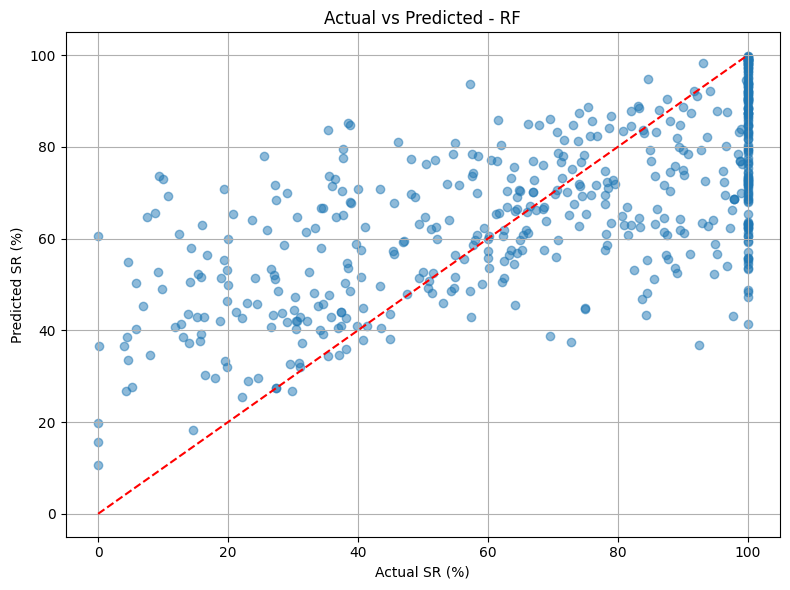


XGB:
RMSE: 22.07
MAE: 16.63
R2 Score: 0.479
CV Score (R2): 0.440 ± 0.028


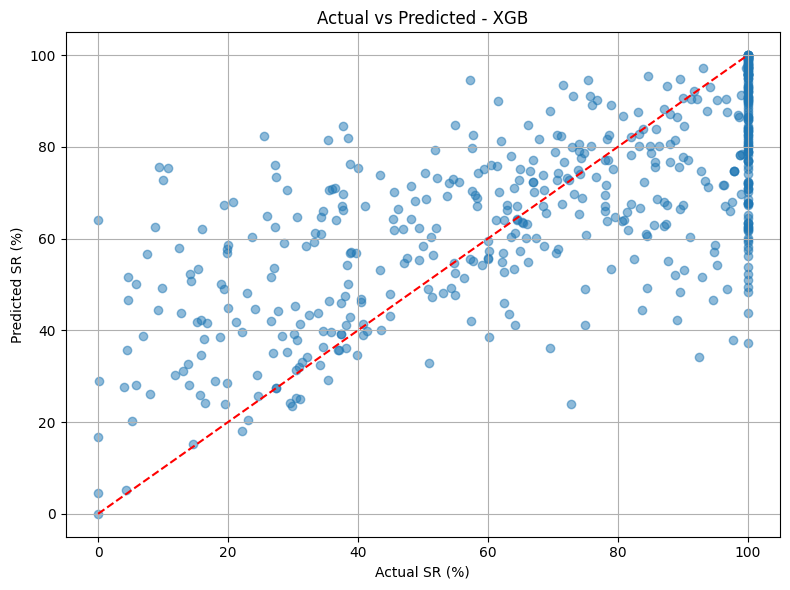


LGB:
RMSE: 23.04
MAE: 17.16
R2 Score: 0.433
CV Score (R2): 0.409 ± 0.035


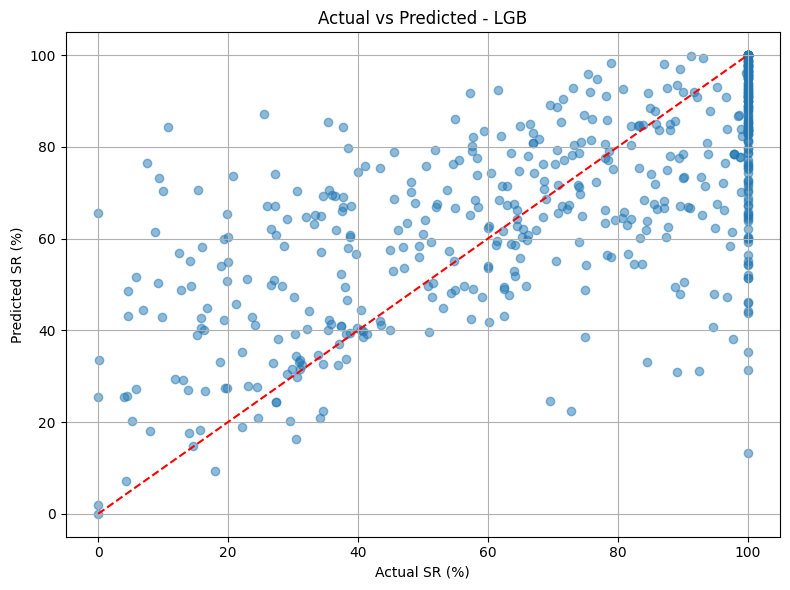

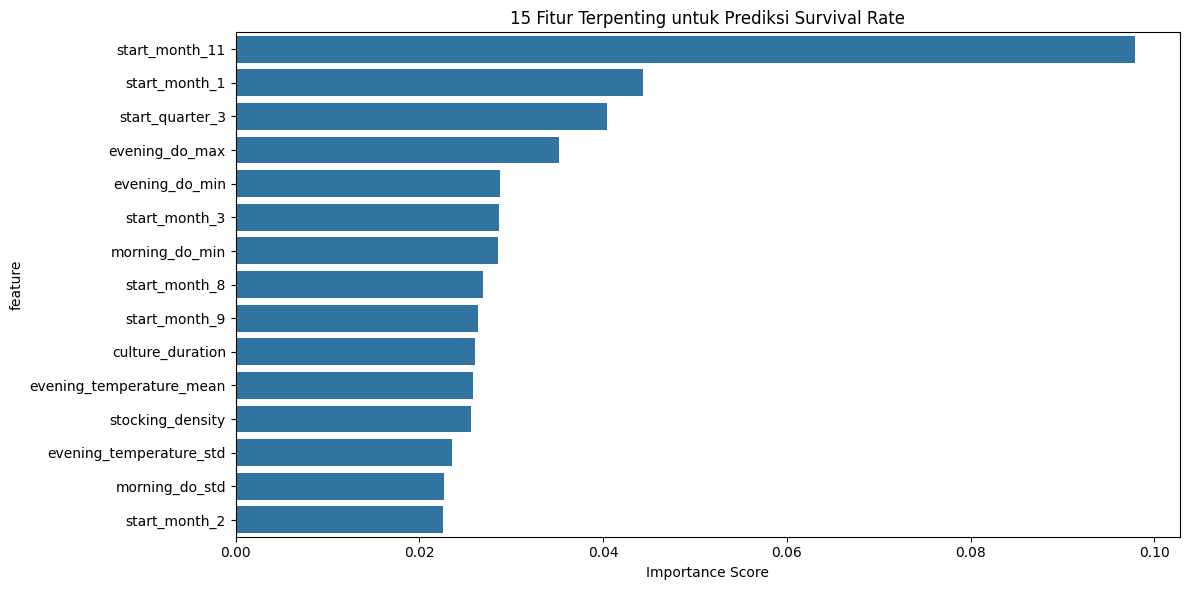

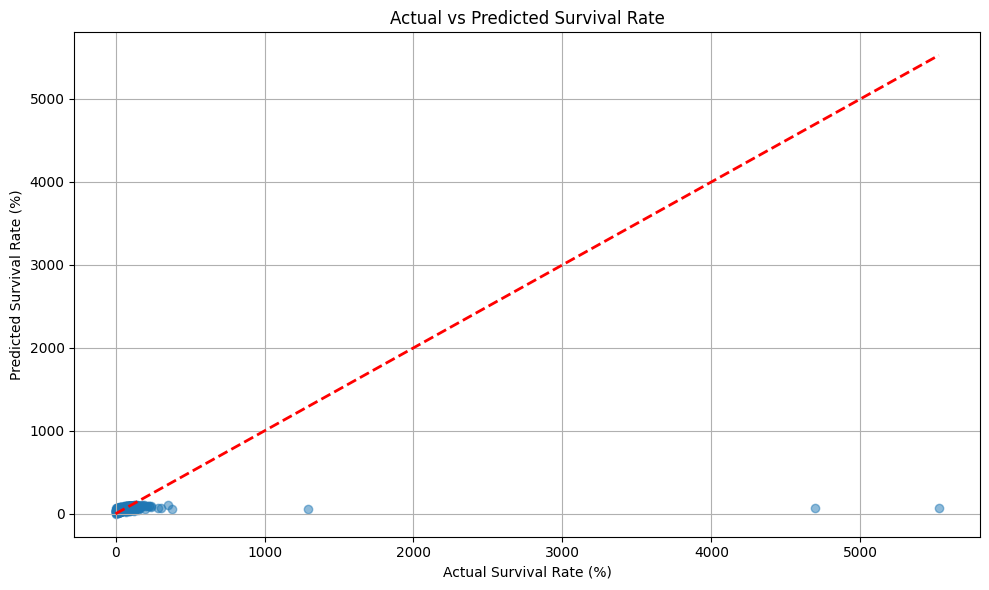

In [6]:
# MAIN EXCECUTION
print("Loading dataset...")
main_df = load_processed_data()

if main_df is not None:
    # Siapkan data untuk model SR
    print("\nMenyiapkan data untuk model Survival Rate...")
    X_sr, y_sr = prepare_features(main_df, target_type='sr')
    
    if len(X_sr) > 0 and len(y_sr) > 0:
        print("\nMembagi data menjadi training dan testing set...")
        X_train_sr, X_test_sr, y_train_sr, y_test_sr, scaler_sr = split_data(X_sr, y_sr)
        
        # Train dan evaluasi model SR
        print("\nMemulai proses training model...")
        sr_model = SurvivalRateModel()
        sr_results = sr_model.train_and_evaluate(X_train_sr, X_test_sr, y_train_sr, y_test_sr)
        
        # Plot actual vs predicted untuk model terbaik
        if sr_model.best_model is not None:
            y_pred_sr = sr_model.best_model.predict(X_test_sr)
            plt.figure(figsize=(10, 6))
            plt.scatter(y_test_sr, y_pred_sr, alpha=0.5)
            plt.plot([y_test_sr.min(), y_test_sr.max()], [y_test_sr.min(), y_test_sr.max()], 'r--', lw=2)
            plt.xlabel('Actual Survival Rate (%)')
            plt.ylabel('Predicted Survival Rate (%)')
            plt.title('Actual vs Predicted Survival Rate')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        print("Tidak ada data yang valid untuk training model setelah penanganan missing values")
else:
    print("Gagal memuat dataset")

Model untuk Average Body Weight (ABW)

In [7]:
class ABWModel:
    def __init__(self):
        self.models = {
            'rf': RandomForestRegressor(
                n_estimators=200,
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=42
            ),
            'xgb': xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                random_state=42
            ),
            'lgb': lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
        }
        self.best_model = None
        self.best_score = float('-inf')
        self.feature_importance = None
    
    def optimize_hyperparameters(self, X_train, y_train, model_type='rf'):
        """
        Optimasi hyperparameter menggunakan RandomizedSearchCV
        """
        print(f"\nMelakukan optimasi hyperparameter untuk model {model_type}...")
        
        if model_type == 'rf':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': [None] + list(range(5, 30)),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10)
            }
            base_model = RandomForestRegressor(random_state=42)
        
        elif model_type == 'xgb':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'min_child_weight': randint(1, 7)
            }
            base_model = xgb.XGBRegressor(random_state=42)
        
        elif model_type == 'lgb':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'num_leaves': randint(20, 100),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4)
            }
            base_model = lgb.LGBMRegressor(random_state=42)
        
        random_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_distributions,
            n_iter=20,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train, y_train)
        print(f"Best parameters for {model_type}: {random_search.best_params_}")
        return random_search.best_estimator_
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        print("\nMemulai training dan evaluasi model ABW...")
        results = {}
        
        # Normalisasi target variable (remove extreme outliers)
        q1 = y_train.quantile(0.01)
        q3 = y_train.quantile(0.99)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        y_train_normalized = np.clip(y_train, lower_bound, upper_bound)
        y_test_normalized = np.clip(y_test, lower_bound, upper_bound)
        
        for name, model in self.models.items():
            print(f"\nTraining model {name}...")
            
            try:
                # Optimasi hyperparameter
                optimized_model = self.optimize_hyperparameters(X_train, y_train_normalized, name)
                self.models[name] = optimized_model
                
                # Train model
                optimized_model.fit(X_train, y_train_normalized)
                
                # Make predictions
                y_pred = optimized_model.predict(X_test)
                y_pred = np.clip(y_pred, lower_bound, upper_bound)
                
                # Calculate metrics
                mse = mean_squared_error(y_test_normalized, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test_normalized, y_pred)
                r2 = r2_score(y_test_normalized, y_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(
                    optimized_model, 
                    X_train, 
                    y_train_normalized,
                    cv=5,
                    scoring='r2',
                    n_jobs=-1
                )
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
                
                results[name] = {
                    'model': optimized_model,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'cv_mean': cv_mean,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                if cv_mean > self.best_score:
                    self.best_score = cv_mean
                    self.best_model = optimized_model
                    
                    if hasattr(optimized_model, 'feature_importances_'):
                        self.feature_importance = pd.DataFrame({
                            'feature': X_train.columns,
                            'importance': optimized_model.feature_importances_
                        }).sort_values('importance', ascending=False)
                
                print(f"Model {name} selesai ditraining")
                
            except Exception as e:
                print(f"Error pada model {name}: {str(e)}")
                continue
        
        # Print results
        print("\nHasil Evaluasi Model ABW:")
        for name, metrics in results.items():
            print(f"\n{name.upper()}:")
            print(f"RMSE: {metrics['rmse']:.2f} gram")
            print(f"MAE: {metrics['mae']:.2f} gram")
            print(f"R2 Score: {metrics['r2']:.3f}")
            print(f"CV Score (R2): {metrics['cv_mean']:.3f} ± {metrics['cv_std']:.3f}")
            
            # Plot actual vs predicted
            plt.figure(figsize=(8, 6))
            plt.scatter(y_test_normalized, metrics['predictions'], alpha=0.5)
            plt.plot([y_test_normalized.min(), y_test_normalized.max()], 
                    [y_test_normalized.min(), y_test_normalized.max()], 'r--')
            plt.xlabel('Actual ABW (gram)')
            plt.ylabel('Predicted ABW (gram)')
            plt.title(f'Actual vs Predicted - {name.upper()}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        # Plot feature importance
        if self.feature_importance is not None:
            plt.figure(figsize=(12, 6))
            sns.barplot(data=self.feature_importance.head(15), x='importance', y='feature')
            plt.title('15 Fitur Terpenting untuk Prediksi ABW')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()
        
        return results

Model untuk Metrik Tambahan (FCR)

In [8]:
class FCRModel:
    def __init__(self):
        self.models = {
            'rf': RandomForestRegressor(
                n_estimators=200,
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=42
            ),
            'xgb': xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                random_state=42
            ),
            'lgb': lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
        }
        self.best_model = None
        self.best_score = float('-inf')
        self.feature_importance = None
    
    def optimize_hyperparameters(self, X_train, y_train, model_type='rf'):
        """
        Optimasi hyperparameter menggunakan RandomizedSearchCV
        """
        print(f"\nMelakukan optimasi hyperparameter untuk model {model_type}...")
        
        if model_type == 'rf':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': [None] + list(range(5, 30)),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10)
            }
            base_model = RandomForestRegressor(random_state=42)
        
        elif model_type == 'xgb':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'min_child_weight': randint(1, 7)
            }
            base_model = xgb.XGBRegressor(random_state=42)
        
        elif model_type == 'lgb':
            param_distributions = {
                'n_estimators': randint(100, 500),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'num_leaves': randint(20, 100),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4)
            }
            base_model = lgb.LGBMRegressor(random_state=42)
        
        random_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_distributions,
            n_iter=20,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train, y_train)
        print(f"Best parameters for {model_type}: {random_search.best_params_}")
        return random_search.best_estimator_
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        print("\nMemulai training dan evaluasi model FCR...")
        results = {}
        
        # Normalisasi target variable (FCR biasanya antara 0.8 - 3.0)
        y_train_normalized = np.clip(y_train, 0.5, 3.0)
        y_test_normalized = np.clip(y_test, 0.5, 3.0)
        
        for name, model in self.models.items():
            print(f"\nTraining model {name}...")
            
            try:
                # Optimasi hyperparameter
                optimized_model = self.optimize_hyperparameters(X_train, y_train_normalized, name)
                self.models[name] = optimized_model
                
                # Train model
                optimized_model.fit(X_train, y_train_normalized)
                
                # Make predictions
                y_pred = optimized_model.predict(X_test)
                y_pred = np.clip(y_pred, 0.5, 3.0)
                
                # Calculate metrics
                mse = mean_squared_error(y_test_normalized, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test_normalized, y_pred)
                r2 = r2_score(y_test_normalized, y_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(
                    optimized_model, 
                    X_train, 
                    y_train_normalized,
                    cv=5,
                    scoring='r2',
                    n_jobs=-1
                )
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
                
                results[name] = {
                    'model': optimized_model,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'cv_mean': cv_mean,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                if cv_mean > self.best_score:
                    self.best_score = cv_mean
                    self.best_model = optimized_model
                    
                    if hasattr(optimized_model, 'feature_importances_'):
                        self.feature_importance = pd.DataFrame({
                            'feature': X_train.columns,
                            'importance': optimized_model.feature_importances_
                        }).sort_values('importance', ascending=False)
                
                print(f"Model {name} selesai ditraining")
                
            except Exception as e:
                print(f"Error pada model {name}: {str(e)}")
                continue
        
        # Print results
        print("\nHasil Evaluasi Model FCR:")
        for name, metrics in results.items():
            print(f"\n{name.upper()}:")
            print(f"RMSE: {metrics['rmse']:.3f}")
            print(f"MAE: {metrics['mae']:.3f}")
            print(f"R2 Score: {metrics['r2']:.3f}")
            print(f"CV Score (R2): {metrics['cv_mean']:.3f} ± {metrics['cv_std']:.3f}")
            
            # Plot actual vs predicted
            plt.figure(figsize=(8, 6))
            plt.scatter(y_test_normalized, metrics['predictions'], alpha=0.5)
            plt.plot([0.5, 3.0], [0.5, 3.0], 'r--')
            plt.xlabel('Actual FCR')
            plt.ylabel('Predicted FCR')
            plt.title(f'Actual vs Predicted - {name.upper()}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
        # Plot feature importance
        if self.feature_importance is not None:
            plt.figure(figsize=(12, 6))
            sns.barplot(data=self.feature_importance.head(15), x='importance', y='feature')
            plt.title('15 Fitur Terpenting untuk Prediksi FCR')
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()
        
        return results


Menyiapkan data untuk model ABW...

Menyiapkan data untuk model ABW

Jumlah missing values sebelum penanganan:
Features:
176 total missing values in features

Target:
199 missing values in target

Setelah penanganan missing values:
Jumlah sampel: 2418
Jumlah fitur: 51

Fitur yang digunakan:
['stocking_density', 'culture_duration', 'temp_daily_fluctuation', 'morning_temperature_mean', 'morning_temperature_min', 'morning_temperature_max', 'morning_temperature_std', 'evening_temperature_mean', 'evening_temperature_min', 'evening_temperature_max', 'evening_temperature_std', 'morning_do_mean', 'morning_do_min', 'morning_do_max', 'morning_do_std', 'evening_do_mean', 'evening_do_min', 'evening_do_max', 'evening_do_std', 'morning_salinity_mean', 'morning_salinity_min', 'morning_salinity_max', 'morning_salinity_std', 'evening_salinity_mean', 'evening_salinity_min', 'evening_salinity_max', 'evening_salinity_std', 'morning_pH_mean', 'morning_pH_min', 'morning_pH_max', 'morning_pH_std', 'evening_

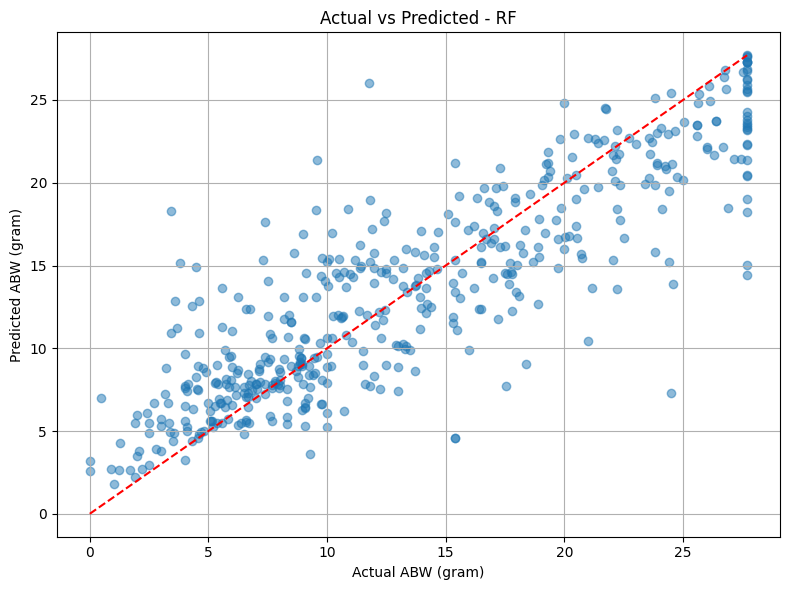


XGB:
RMSE: 3.69 gram
MAE: 2.58 gram
R2 Score: 0.770
CV Score (R2): 0.770 ± 0.012


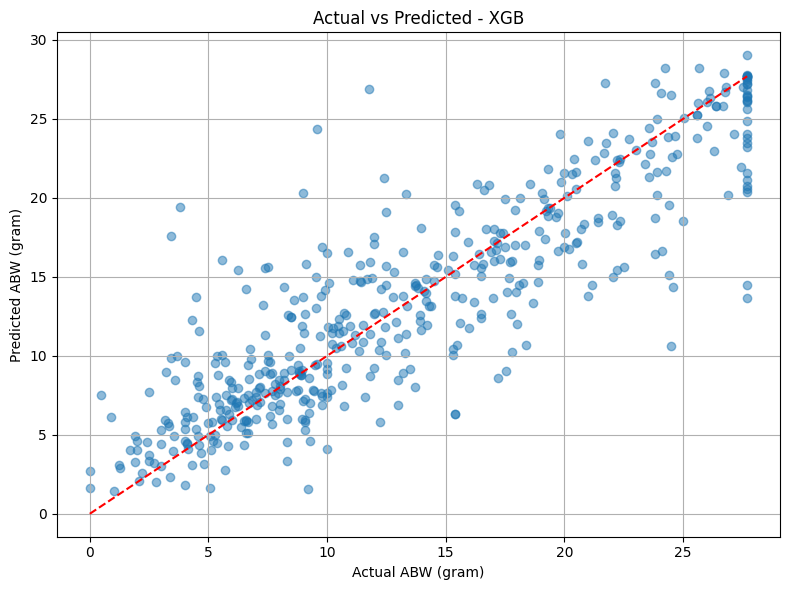


LGB:
RMSE: 3.71 gram
MAE: 2.62 gram
R2 Score: 0.767
CV Score (R2): 0.756 ± 0.018


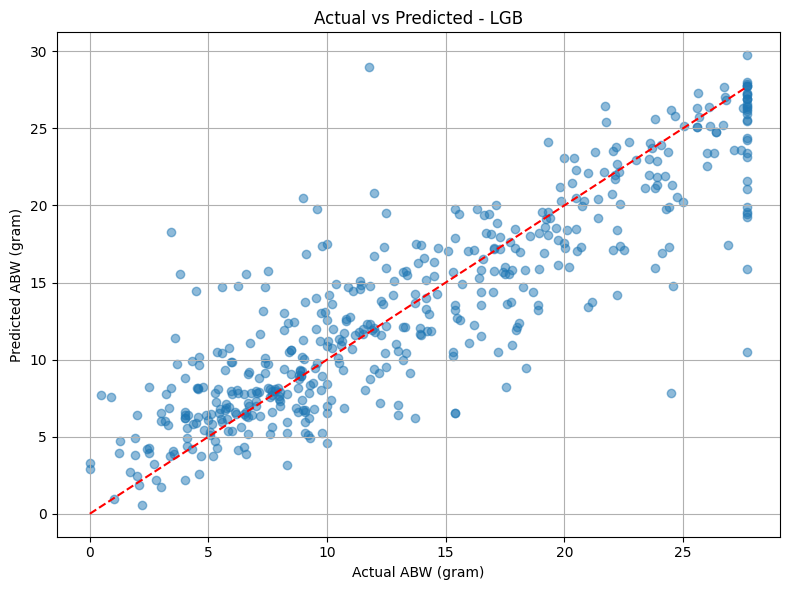

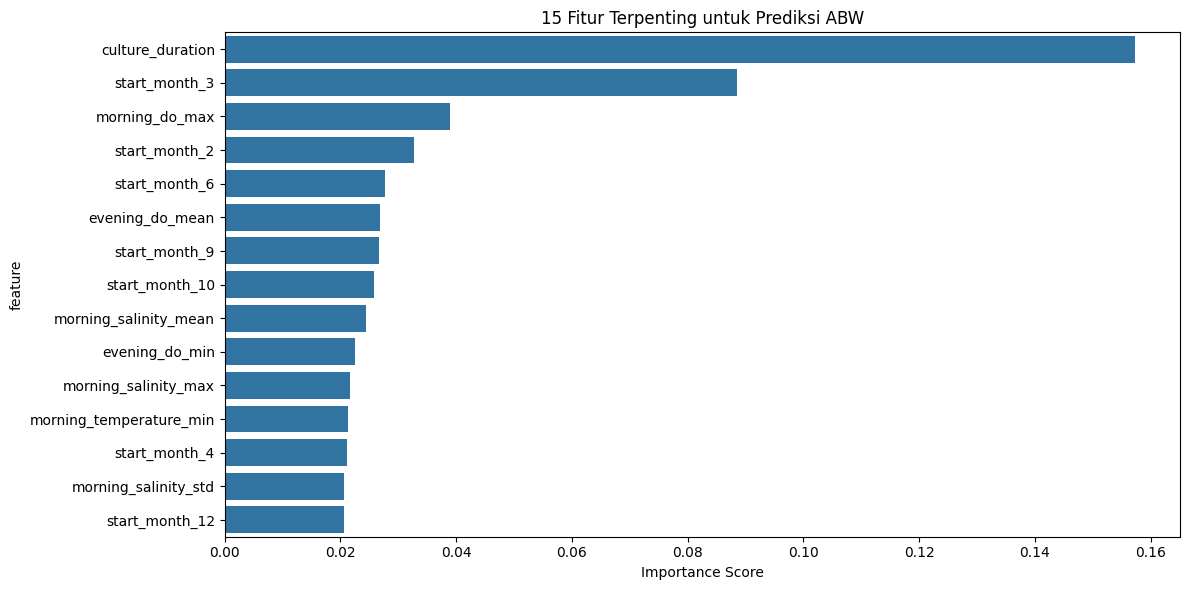


Menyiapkan data untuk model FCR...

Menyiapkan data untuk model FCR

Jumlah missing values sebelum penanganan:
Features:
176 total missing values in features

Target:
199 missing values in target

Setelah penanganan missing values:
Jumlah sampel: 2418
Jumlah fitur: 51

Fitur yang digunakan:
['stocking_density', 'culture_duration', 'temp_daily_fluctuation', 'morning_temperature_mean', 'morning_temperature_min', 'morning_temperature_max', 'morning_temperature_std', 'evening_temperature_mean', 'evening_temperature_min', 'evening_temperature_max', 'evening_temperature_std', 'morning_do_mean', 'morning_do_min', 'morning_do_max', 'morning_do_std', 'evening_do_mean', 'evening_do_min', 'evening_do_max', 'evening_do_std', 'morning_salinity_mean', 'morning_salinity_min', 'morning_salinity_max', 'morning_salinity_std', 'evening_salinity_mean', 'evening_salinity_min', 'evening_salinity_max', 'evening_salinity_std', 'morning_pH_mean', 'morning_pH_min', 'morning_pH_max', 'morning_pH_std', 'evening_

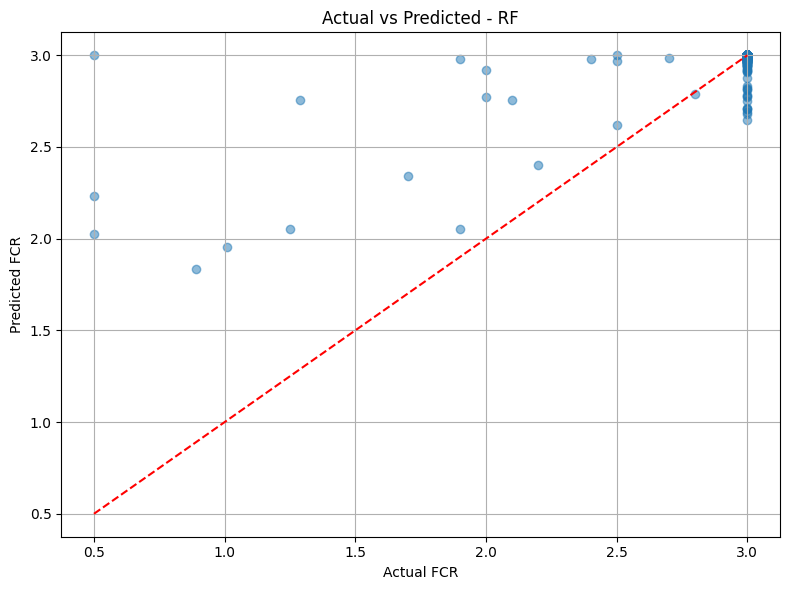


XGB:
RMSE: 0.206
MAE: 0.048
R2 Score: 0.495
CV Score (R2): 0.338 ± 0.292


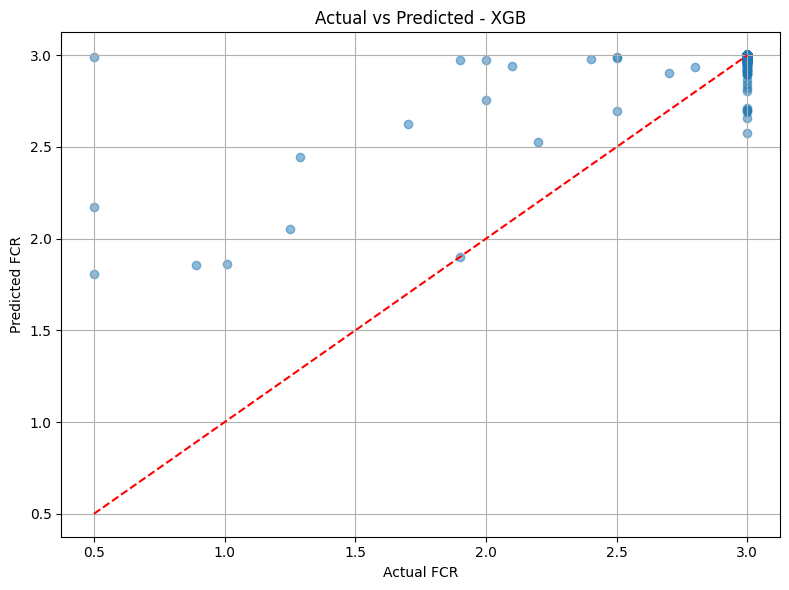


LGB:
RMSE: 0.179
MAE: 0.044
R2 Score: 0.619
CV Score (R2): 0.355 ± 0.319


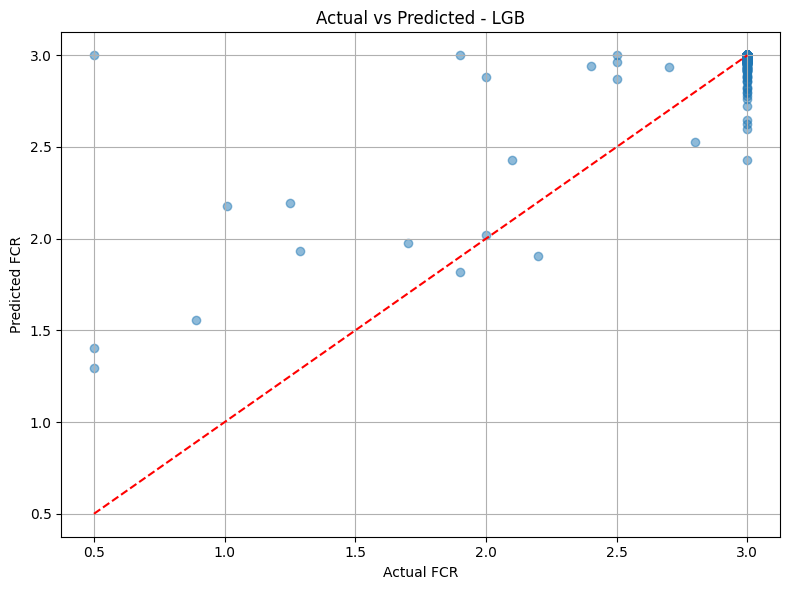

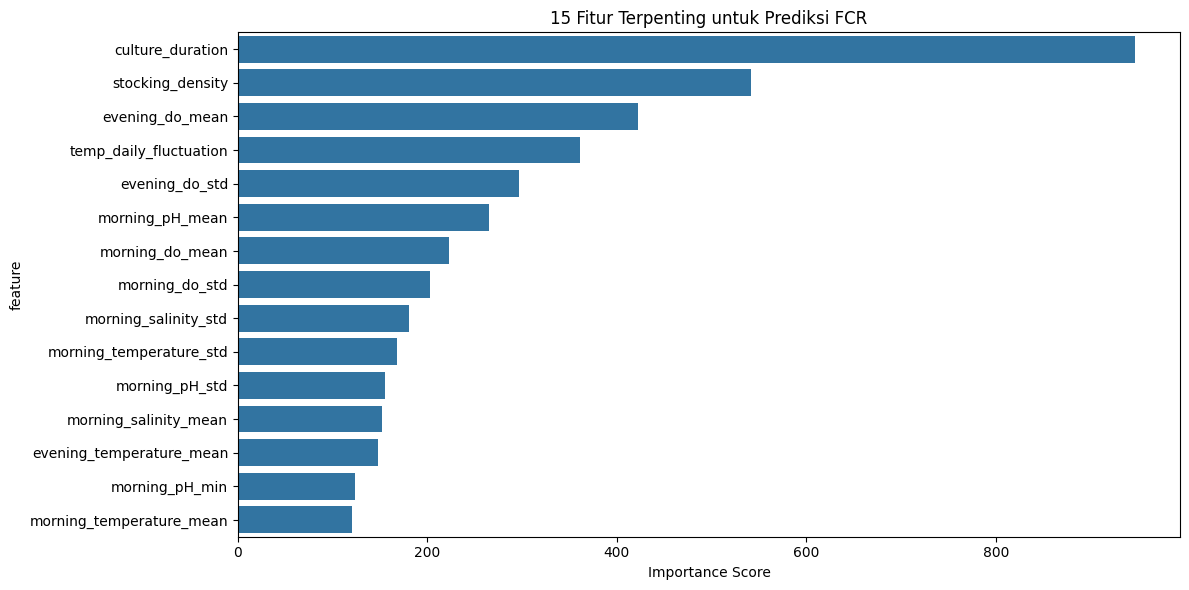

In [9]:
# MAIN EXCECUTION
if main_df is not None:
    # Train dan evaluasi model ABW
    if 'average_weight' in main_df.columns:
        print("\nMenyiapkan data untuk model ABW...")
        X_abw, y_abw = prepare_features(main_df, target_type='abw')
        if len(X_abw) > 0 and len(y_abw) > 0:
            split_result = split_data(X_abw, y_abw)
            if all(v is not None for v in split_result):
                X_train_abw, X_test_abw, y_train_abw, y_test_abw, scaler_abw = split_result
                abw_model = ABWModel()
                abw_results = abw_model.train_and_evaluate(X_train_abw, X_test_abw, y_train_abw, y_test_abw)
    
    # Train dan evaluasi model FCR
    if 'fcr' in main_df.columns:
        print("\nMenyiapkan data untuk model FCR...")
        X_fcr, y_fcr = prepare_features(main_df, target_type='fcr')
        if len(X_fcr) > 0 and len(y_fcr) > 0:
            split_result = split_data(X_fcr, y_fcr)
            if all(v is not None for v in split_result):
                X_train_fcr, X_test_fcr, y_train_fcr, y_test_fcr, scaler_fcr = split_result
                fcr_model = FCRModel()
                fcr_results = fcr_model.train_and_evaluate(X_train_fcr, X_test_fcr, y_train_fcr, y_test_fcr)

Simpan Model dan Scaler

In [17]:
def save_models_and_scalers(models_dict, scalers_dict, feature_importances_dict, output_dir='models'):
    """
    Menyimpan model, scaler, dan feature importance
    """
    import joblib
    import json
    from datetime import datetime
    
    # Buat direktori dengan timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_dir = os.path.join(output_dir, f'model_export_{timestamp}')
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"\nDibuat direktori baru: {model_dir}")
    
    # Simpan model dan scaler
    for name in models_dict.keys():
        # Simpan model
        model_path = os.path.join(model_dir, f'{name}_model.joblib')
        joblib.dump(models_dict[name], model_path)
        
        # Simpan scaler
        scaler_path = os.path.join(model_dir, f'{name}_scaler.joblib')
        joblib.dump(scalers_dict[name], scaler_path)
        
        # Simpan feature importance jika ada
        if name in feature_importances_dict and feature_importances_dict[name] is not None:
            importance_path = os.path.join(model_dir, f'{name}_feature_importance.csv')
            feature_importances_dict[name].to_csv(importance_path, index=False)
        
        print(f"Model dan scaler untuk {name} disimpan di {model_dir}")
    
    # Simpan metadata
    metadata = {
        'export_time': timestamp,
        'models': list(models_dict.keys()),
        'features': {name: models_dict[name].feature_importances_.shape[0] 
                    for name in models_dict.keys() 
                    if hasattr(models_dict[name], 'feature_importances_')}
    }
    
    metadata_path = os.path.join(model_dir, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    
    return model_dir

Ringkasan Model dan Visualisasi

In [11]:
def create_comprehensive_summary(sr_results, abw_results, fcr_results=None):
    """
    Membuat ringkasan komprehensif dari semua model
    """
    print("\n" + "="*50)
    print("RINGKASAN KOMPREHENSIF MODEL")
    print("="*50)
    
    # Fungsi helper untuk format metrik
    def format_metrics(metrics):
        return {
            'R² Score': f"{metrics['r2']:.3f}",
            'RMSE': f"{metrics['rmse']:.2f}",
            'MAE': f"{metrics['mae']:.2f}",
            'CV Score': f"{metrics['cv_mean']:.3f} ± {metrics['cv_std']:.3f}"
        }
    
    # Buat DataFrame ringkasan
    summary_data = []
    
    # Tambahkan hasil SR
    for model_name, metrics in sr_results.items():
        summary_data.append({
            'Model Type': 'Survival Rate',
            'Algorithm': model_name.upper(),
            **format_metrics(metrics)
        })
    
    # Tambahkan hasil ABW
    for model_name, metrics in abw_results.items():
        summary_data.append({
            'Model Type': 'Average Body Weight',
            'Algorithm': model_name.upper(),
            **format_metrics(metrics)
        })
    
    # Tambahkan hasil FCR jika ada
    if fcr_results:
        for model_name, metrics in fcr_results.items():
            summary_data.append({
                'Model Type': 'FCR',
                'Algorithm': model_name.upper(),
                **format_metrics(metrics)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Tampilkan ringkasan
    print("\nRingkasan Performa Model:")
    print(summary_df.to_string(index=False))
    
    return summary_df

Visualisasi Model

In [15]:
def create_comprehensive_visualization(sr_results, abw_results, fcr_results=None):
    """
    Membuat visualisasi komprehensif untuk semua model
    """
    print("\n" + "="*50)
    print("VISUALISASI KOMPREHENSIF")
    print("="*50)
    
    # 1. Plot perbandingan R² scores
    plt.figure(figsize=(12, 6))
    model_types = []
    r2_scores = []
    algorithms = []
    
    for model_type, results in [('SR', sr_results), ('ABW', abw_results)]:
        for alg, metrics in results.items():
            model_types.append(model_type)
            r2_scores.append(metrics['r2'])
            algorithms.append(alg.upper())
    
    if fcr_results:
        for alg, metrics in fcr_results.items():
            model_types.append('FCR')
            r2_scores.append(metrics['r2'])
            algorithms.append(alg.upper())
    
    df_scores = pd.DataFrame({
        'Model Type': model_types,
        'Algorithm': algorithms,
        'R² Score': r2_scores
    })
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_scores, x='Model Type', y='R² Score', hue='Algorithm')
    plt.title('Perbandingan R² Score Antar Model')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 2. Plot distribusi error untuk setiap model
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Distribusi Error untuk Setiap Model', fontsize=16)
    
    row = 0
    col = 0
    
    # Plot untuk SR models
    for name, metrics in sr_results.items():
        errors = metrics['predictions'] - y_test_sr
        sns.histplot(errors, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'SR - {name.upper()}')
        axes[row, col].set_xlabel('Error')
        col += 1
    
    # Reset column dan pindah ke baris berikutnya
    row = 1
    col = 0
    
    # Plot untuk ABW models
    for name, metrics in abw_results.items():
        errors = metrics['predictions'] - y_test_abw
        sns.histplot(errors, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'ABW - {name.upper()}')
        axes[row, col].set_xlabel('Error')
        col += 1
    
    plt.tight_layout()
    plt.show()
    
    # 3. Feature Importance Comparison
    if hasattr(sr_model, 'feature_importance') and hasattr(abw_model, 'feature_importance'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # SR Feature Importance
        sns.barplot(data=sr_model.feature_importance.head(10), 
                   x='importance', y='feature', ax=ax1)
        ax1.set_title('Top 10 Features - Survival Rate')
        
        # ABW Feature Importance
        sns.barplot(data=abw_model.feature_importance.head(10), 
                   x='importance', y='feature', ax=ax2)
        ax2.set_title('Top 10 Features - Average Body Weight')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Actual vs Predicted Scatter Plots Matrix
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Actual vs Predicted untuk Semua Model', fontsize=16)
    
    row = 0
    col = 0
    
    # Plot untuk SR models
    for name, metrics in sr_results.items():
        axes[row, col].scatter(y_test_sr, metrics['predictions'], alpha=0.5)
        axes[row, col].plot([y_test_sr.min(), y_test_sr.max()], 
                          [y_test_sr.min(), y_test_sr.max()], 'r--')
        axes[row, col].set_title(f'SR - {name.upper()}')
        axes[row, col].set_xlabel('Actual')
        axes[row, col].set_ylabel('Predicted')
        axes[row, col].grid(True)
        col += 1
    
    # Reset column dan pindah ke baris berikutnya
    row = 1
    col = 0
    
    # Plot untuk ABW models
    for name, metrics in abw_results.items():
        axes[row, col].scatter(y_test_abw, metrics['predictions'], alpha=0.5)
        axes[row, col].plot([y_test_abw.min(), y_test_abw.max()], 
                          [y_test_abw.min(), y_test_abw.max()], 'r--')
        axes[row, col].set_title(f'ABW - {name.upper()}')
        axes[row, col].set_xlabel('Actual')
        axes[row, col].set_ylabel('Predicted')
        axes[row, col].grid(True)
        col += 1
    
    plt.tight_layout()
    plt.show()


Dibuat direktori baru: models\model_export_20250327_003853
Model dan scaler untuk sr disimpan di models\model_export_20250327_003853
Model dan scaler untuk abw disimpan di models\model_export_20250327_003853
Model dan scaler untuk fcr disimpan di models\model_export_20250327_003853

RINGKASAN KOMPREHENSIF MODEL

Ringkasan Performa Model:
         Model Type Algorithm R² Score  RMSE   MAE      CV Score
      Survival Rate        RF    0.440 22.89 17.85 0.409 ± 0.017
      Survival Rate       XGB    0.479 22.07 16.63 0.440 ± 0.028
      Survival Rate       LGB    0.433 23.04 17.16 0.409 ± 0.035
Average Body Weight        RF    0.751  3.83  2.81 0.745 ± 0.022
Average Body Weight       XGB    0.770  3.69  2.58 0.770 ± 0.012
Average Body Weight       LGB    0.767  3.71  2.62 0.756 ± 0.018
                FCR        RF    0.469  0.21  0.05 0.303 ± 0.373
                FCR       XGB    0.495  0.21  0.05 0.338 ± 0.292
                FCR       LGB    0.619  0.18  0.04 0.355 ± 0.319

VISUALIS

<Figure size 1200x600 with 0 Axes>

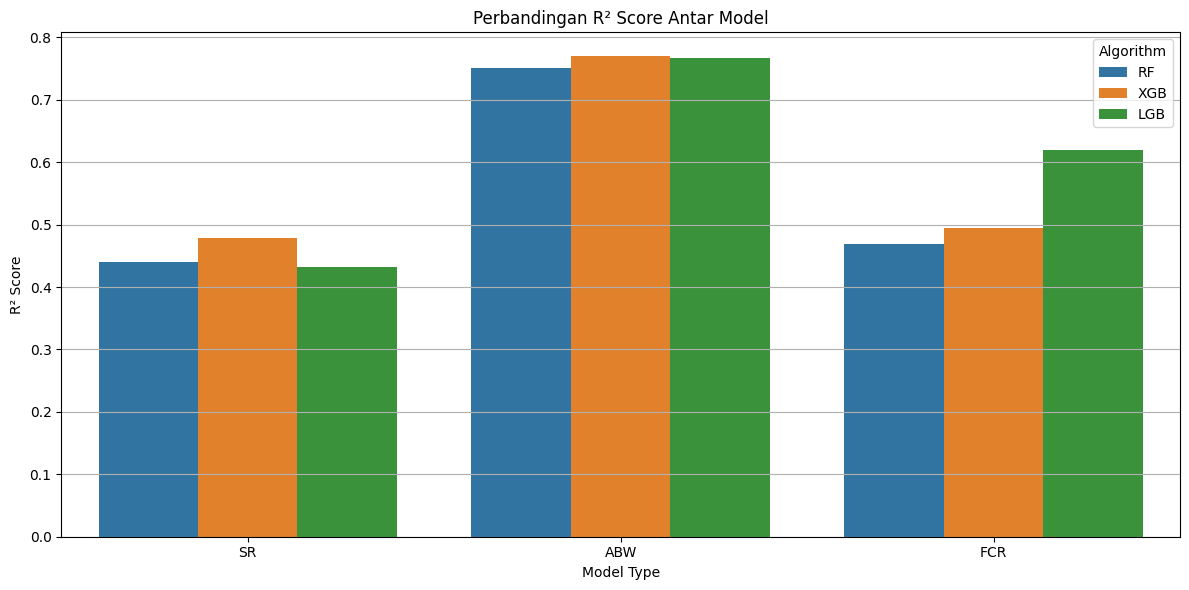

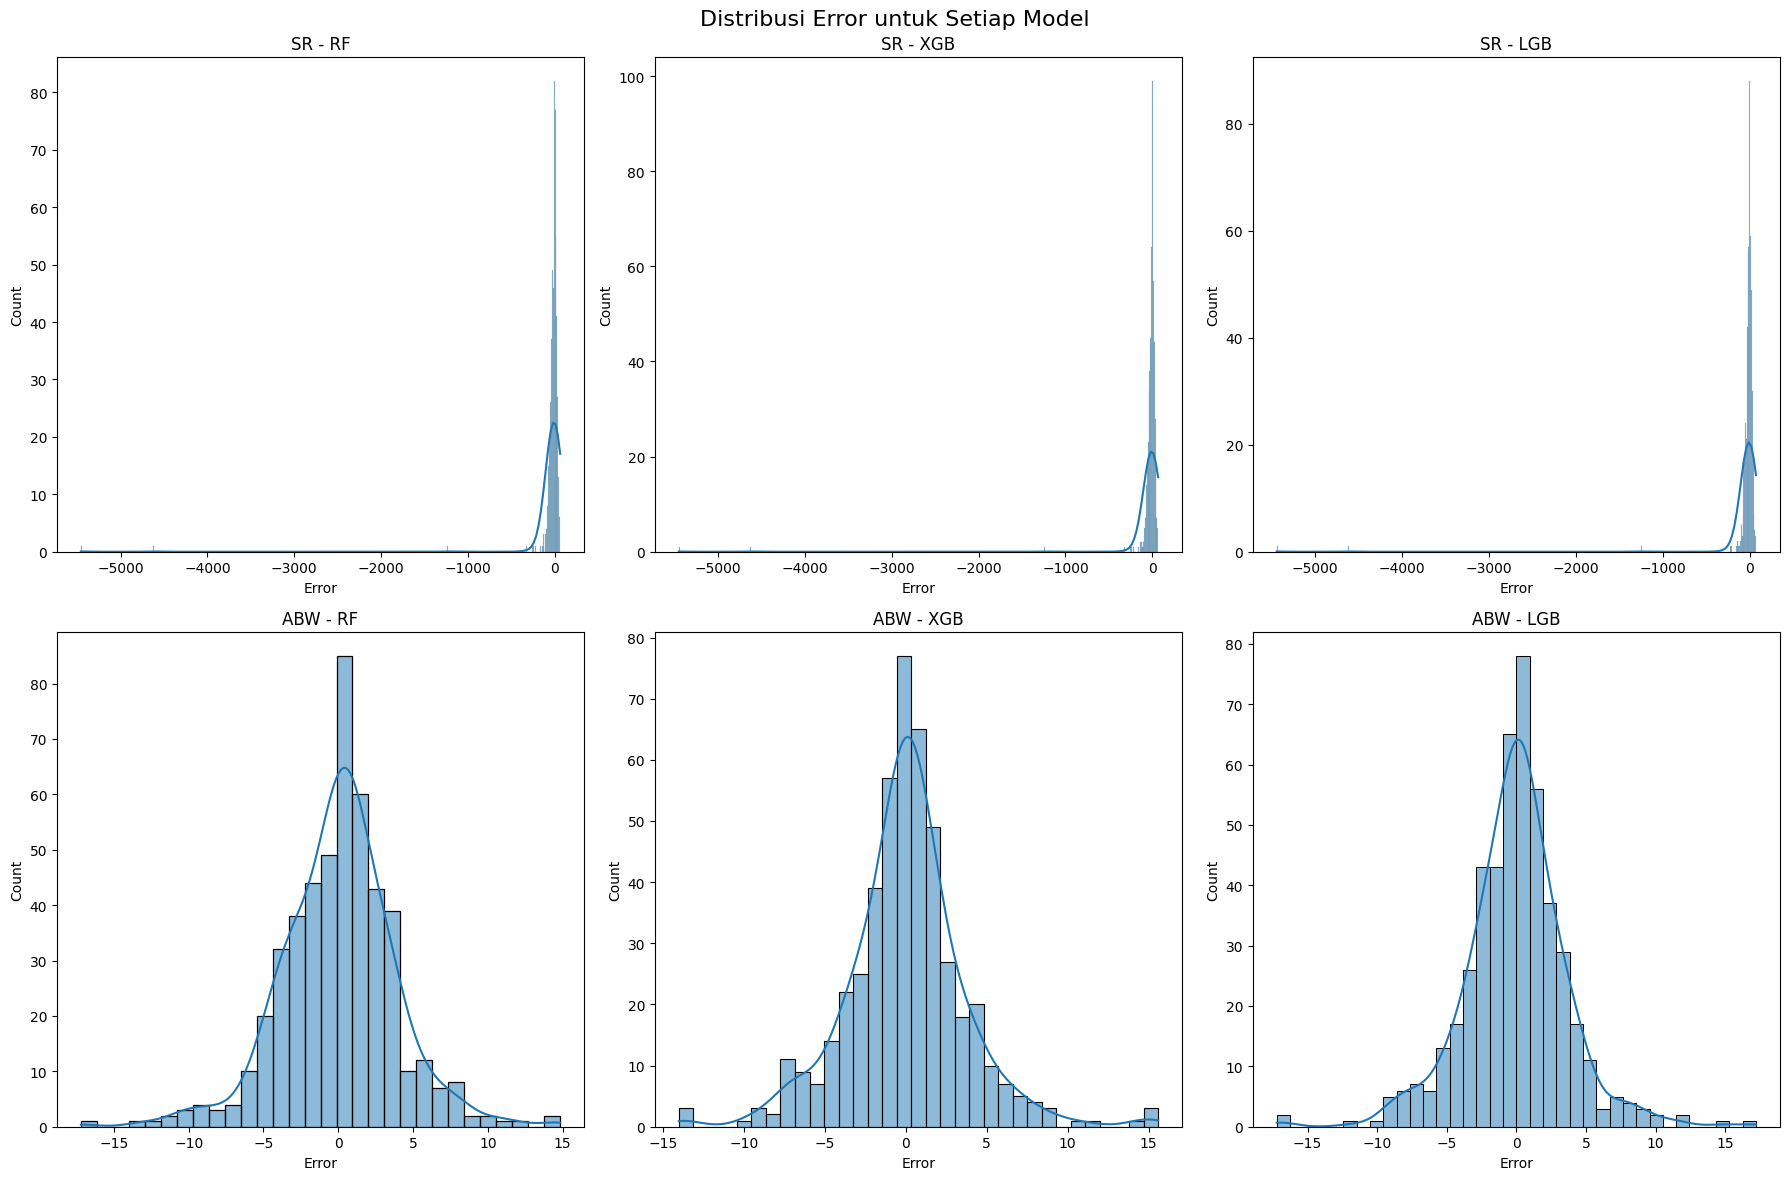

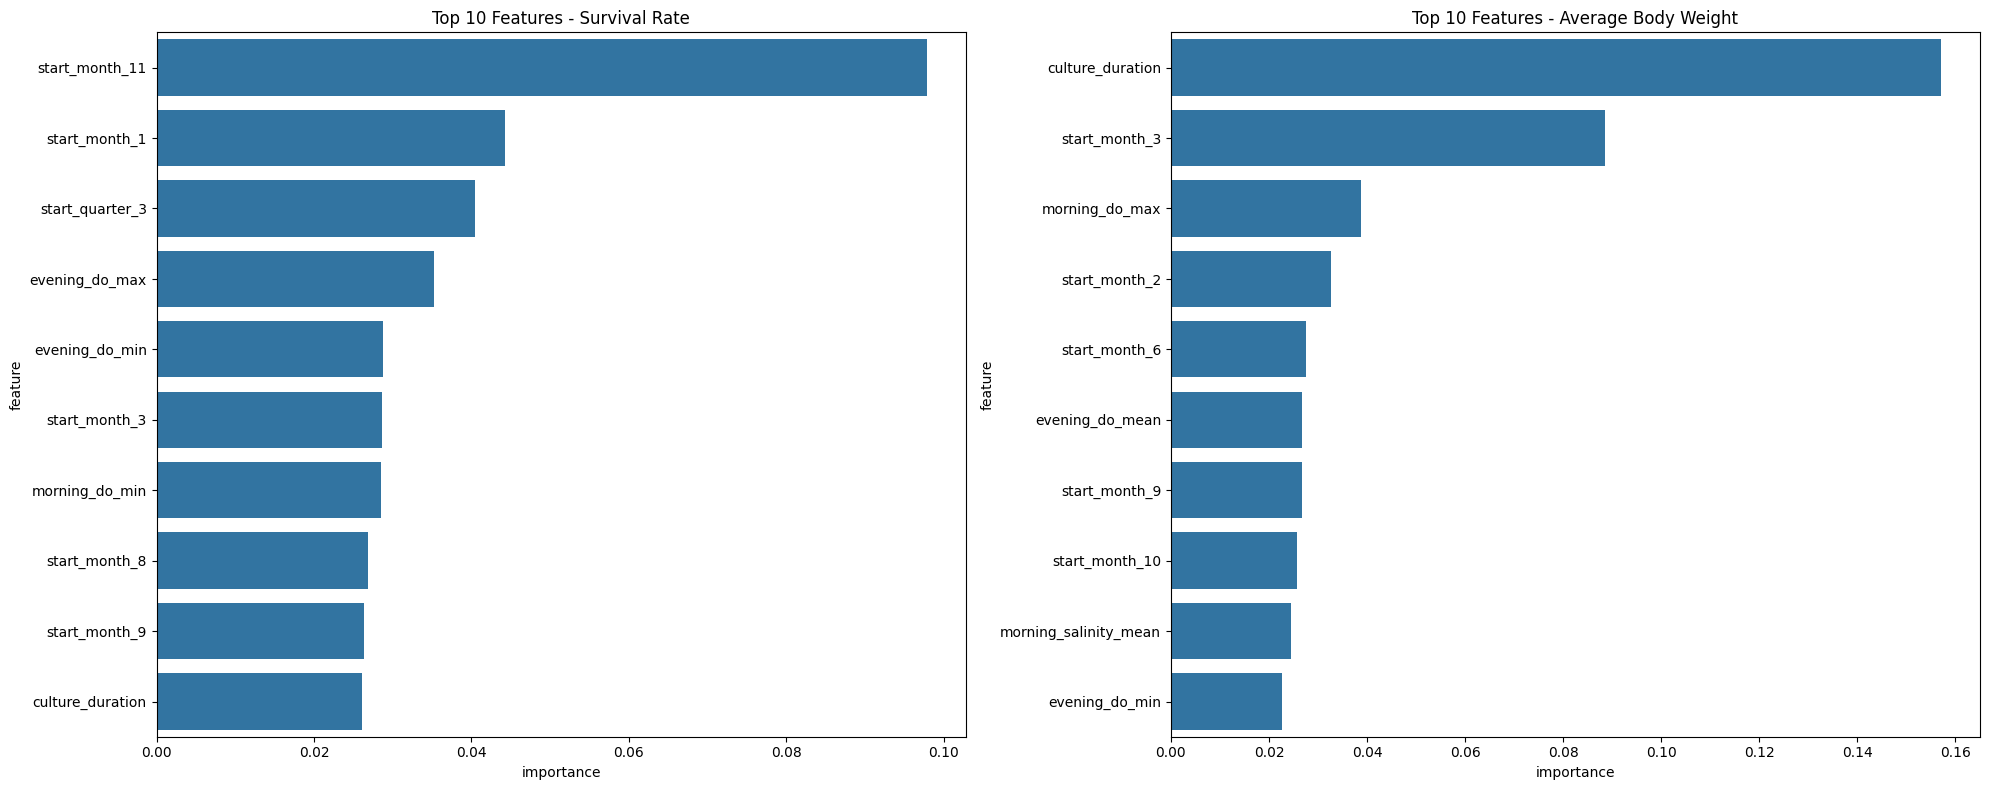

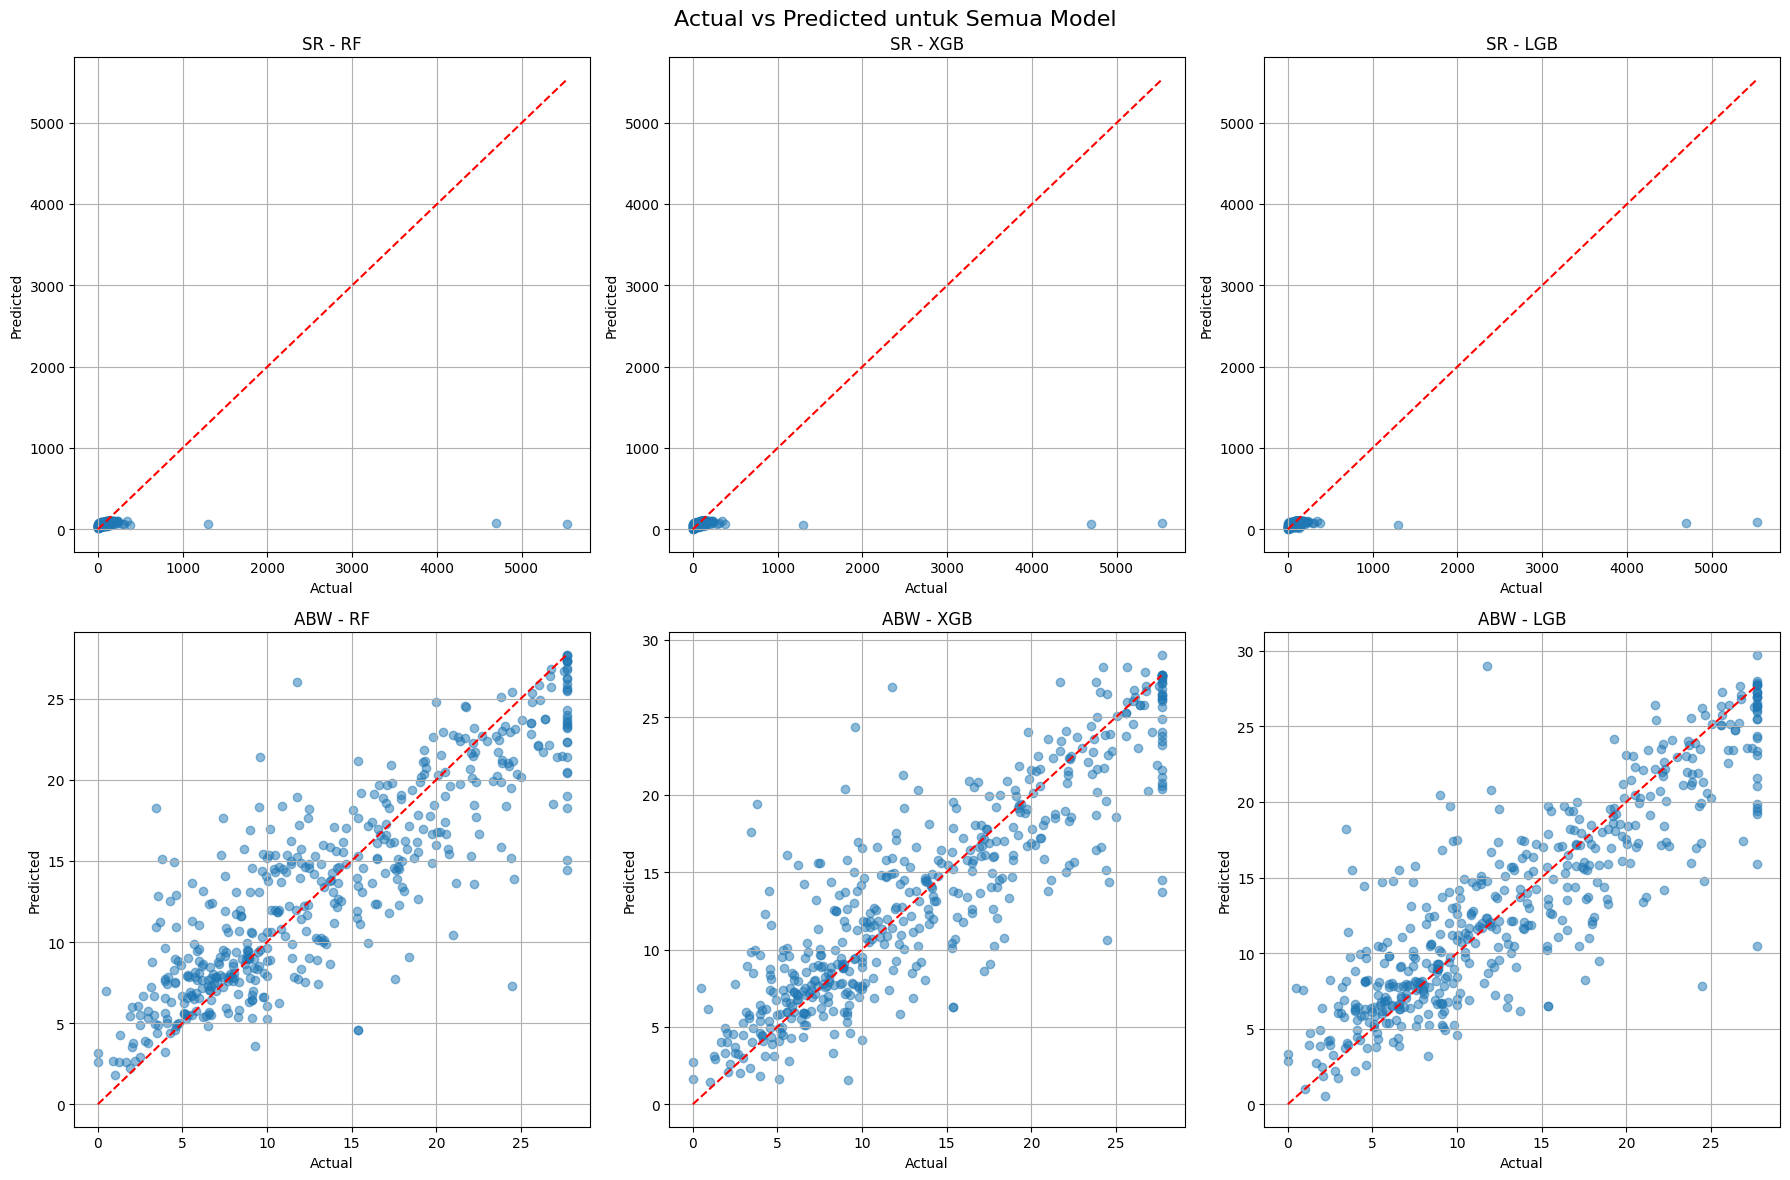


Ringkasan model disimpan di: models\model_export_20250327_003853\model_summary.csv

Proses selesai! Semua model, scaler, dan ringkasan telah disimpan.


In [20]:
# MAIN EXCECUTION
import os

if 'sr_results' in locals() and 'abw_results' in locals():
    # Siapkan dictionary untuk model dan scaler
    models_dict = {
        'sr': sr_model.best_model,
        'abw': abw_model.best_model
    }
    
    scalers_dict = {
        'sr': scaler_sr,
        'abw': scaler_abw
    }
    
    feature_importances_dict = {
        'sr': sr_model.feature_importance,
        'abw': abw_model.feature_importance
    }
    
    # Tambahkan FCR
    if 'fcr_results' in locals():
        models_dict['fcr'] = fcr_model.best_model
        scalers_dict['fcr'] = scaler_fcr
        feature_importances_dict['fcr'] = fcr_model.feature_importance
    
    # Simpan model dan scaler
    model_dir = save_models_and_scalers(models_dict, scalers_dict, feature_importances_dict)
    
    # Buat ringkasan
    fcr_results = fcr_results if 'fcr_results' in locals() else None
    summary_df = create_comprehensive_summary(sr_results, abw_results, fcr_results)
    
    # Buat visualisasi
    create_comprehensive_visualization(sr_results, abw_results, fcr_results)
    
    # Simpan ringkasan ke file
    summary_path = os.path.join(model_dir, 'model_summary.csv')
    summary_df.to_csv(summary_path, index=False)
    print(f"\nRingkasan model disimpan di: {summary_path}")
    
    print("\nProses selesai! Semua model, scaler, dan ringkasan telah disimpan.")
else:
    print("Model belum ditraining. Jalankan training terlebih dahulu.")

## Deployment API